<a href="https://colab.research.google.com/github/HenryHollis/pythonMachineLearning/blob/master/Project2_Part2_Hollis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Option 3: ANN With a Hidden Layer

In [1]:
#All my imports
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import keras  #for MNIST data

In [2]:
#bring in my MNIST data
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data(path="mnist.npz")


In [3]:
# Reshape the training and test examples
y_train = y_train.reshape((60000, 1))
y_test = y_test.reshape((10000, 1))
X_train= X_train.reshape(X_train.shape[0], -1).T
X_test = X_test.reshape(X_test.shape[0], -1).T

print ("X_train shape: " + str(X_train.shape))  # This is the format Dr. Ng suggests
print ("y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("y_test shape: " + str(y_test.shape))

X_train = X_train/255.   # normalize px values
X_test = X_test/255.

X_train shape: (784, 60000)
y_train shape: (60000, 1)
X_test shape: (784, 10000)
y_test shape: (10000, 1)


In [4]:
# Making categorical data:
def one_hot_encode(labels):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc = enc.fit_transform(labels).toarray()
    return enc.T

# Rectified Linear Unit (ReLU) activation function
def Relu(Z):
    return np.maximum(0,Z)  

# derivative of ReLU
def dRelu(x):
    x[x<=0] = 0  
    x[x>0] = 1
    return x

#Remember, Relu has a piecewise deriv.
def dRelu2(dZ, Z):    
    dZ[Z <= 0] = 0    
    return dZ

# Defining my activation function for output layer
def softmax(x):  
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# derivative of softmax (also sigmoid)
def d_softmax(Z):
    s = 1/(1+np.exp(-Z))
    dZ = s * (1-s)
    return dZ

In [5]:

class digit_classifier: 
    """Here I modified some code I have from my AI class last semester:
     https://github.com/HenryHollis/pythonMachineLearning/blob/master/shroom/Classifying%20Mushrooms.ipynb
     """
    def __init__(self, X_train, y_train, learn_rate = 0.003):
        """ input: X_train: ndarray of shape (numfeatures, numsamples)
                   y_train: ndarray of shape (1, numsamples)
                   learning_rate: float val
        """
        #print(y_train.shape)
        self.X = X_train                           # training input vector size (784, 60000)
        self.Y = one_hot_encode(y_train)           # training output vector size (1, 60000)
        y_train = y_train.T
        #print('X shape', self.X.shape)
        #print('y shape', self.Y.shape)
        self.Yh = np.zeros(self.Y.shape[1]).reshape((1, -1))   # actual outputs of the NN 
        self.L = 2                            # number of layers in our NN
        self.dims = [784, 500, 10]            # dimensions of layers: 784 inputs, 500 units (hidden), 1 output unit
        self.param = {}  
        self.ch = {}                          # dictionary to store intermediate results of forward pass for backprop use
        self.grad = {}
        self.loss = []
        self.train_acc = []
        self.lr = learn_rate                  # learning rate
        self.sam = self.Y.shape[1]            # number of training samples to use
       
    # initialize the network weights with random values instead of zeros like Prof. Ng suggests
    def initialize(self):    
        np.random.seed(1)
        self.param['W1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0]) 
        self.param['b1'] = np.zeros((self.dims[1], 1))        
        self.param['W2'] = np.random.randn(self.dims[2], self.dims[1]) / np.sqrt(self.dims[1]) 
        self.param['b2'] = np.zeros((self.dims[2], 1))          
        # print(self.param['W1'].shape)      
        # print(self.param['b1'].shape)      
        # print(self.param['W2'].shape)      
        # print(self.param['b2'].shape)      

        return
        
    # forward pass of the NN
    def propagate(self, predict = False):
        """
        When predicting we need to use this method but we
        dont care about the loss, hence the parameter "predict"
        """
        Z1 = self.param['W1'].dot(self.X) + self.param['b1'] # score is calculated z1 = W dot X + B
        A1 = Relu(Z1)                                        # This is the preactivation
        self.ch['Z1'],self.ch['A1']=Z1, A1                   # store these results for later backprop
        Z2 = self.param['W2'].dot(A1) + self.param['b2']     # preactivation 2 calculated
        A2 = softmax(Z2)                                     # run through softmax function
        self.ch['Z2'],self.ch['A2']=Z2,A2                    # again, store intermediate results of hidden layer
        self.Yh = A2                                         # final outputs stored in Yh
        loss = np.NAN
        if not predict:
            loss = self.nloss(A2)                            # calculate loss on final output, then return
        return self.Yh, loss
        

    # compute the Loss
    def nloss(self,Yh):
      """
      loss function
      input: ndarry of shape: (numClasses, numSamples)
      """
      loss = (1.0/self.sam) * (-np.dot(self.Y, np.log(Yh).T) - np.dot(1-self.Y, np.log(1-Yh).T))    
      return loss   
    
    # backward pass
    def backward(self):
        """
        backprop using chain rule and
        derivative functions we defined
        """
        dLoss_Yh = - (np.divide(self.Y, self.Yh ) - np.divide(1 - self.Y, 1 - self.Yh))  # derivative of loss function
        #print(self.ch['Z2'].shape)
        dLoss_Z2 = dLoss_Yh * d_softmax(self.ch['Z2'])    # derivative of loss w.r.t. preactivation 2
        dLoss_A1 = np.dot(self.param["W2"].T,dLoss_Z2)   # dloss w.r.t. activation 1

        # using chain rule to find dLoss w.r.t weights and bias for layer 2
        dLoss_W2 = 1.0/self.ch['A1'].shape[1] * np.dot(dLoss_Z2,self.ch['A1'].T)
        dLoss_b2 = 1.0/self.ch['A1'].shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1])) 
                            
        dLoss_Z1 = dLoss_A1 * dRelu(self.ch['Z1'])        
        dLoss_A0 = np.dot(self.param["W1"].T,dLoss_Z1)

        # using chain rule to find dLoss w.r.t weights and bias for layer 1
        dLoss_W1 = 1./self.X.shape[1] * np.dot(dLoss_Z1,self.X.T)
        dLoss_b1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))  
        
        # Adjust the weights and bias accordingly
        self.param["W1"] -= self.lr * dLoss_W1   # adjust weights between input and hidden
        self.param["b1"] -= self.lr * dLoss_b1
        self.param["W2"] -= self.lr * dLoss_W2   # adjust weights between hidden and output
        self.param["b2"] -= self.lr * dLoss_b2 

    def predict(self, X_test, y_test = []): 
        """
        This method has two modes:
        When test labels are supplied via "y_test" 
        it returns validation acc.
        When just test data is supplied it outputs the predictions
        and confidence.
        """
        self.X = X_test                           # training input vector size (784, 10000)
        if len(y_test) > 0:
          self.Y = one_hot_encode(y_test)           # training output vector size (1, 10000)
          y_test = y_test.T
          #print('X shape', self.X.shape)
          #print('y shape', self.Y.shape)
          self.Yh = np.zeros(self.Y.shape[1]).reshape((1, -1))   # actual outputs of the NN 
          pred, loss = self.propagate()
          pred = softmax(pred)
          pred = pred.argmax(axis=0)
          acc = np.mean(pred == np.squeeze(y_test))
          print('Validation Acc: {:.4f}'.format(acc))
          return pred
        else:
          self.Yh = np.array(X_test[1]).reshape((1, -1))
          #print(self.Yh)
          pred,_ = self.propagate(True)
          #print(pred)
          conf = np.amax(pred, axis=0)
          conf = [ '%.2f' % x for x in conf ]
          conf = [ float(x) for x in conf ]
          pred = pred.argmax(axis=0)
          preds_conf = (list(zip(list(pred), list(conf))))
          print("Prediction Complete (prediction, confidence):")
        return (preds_conf)
    
    def fit(self,X, Y, epoch = 2000):
      """ model for training. Used "fit"
           to align with keras convention.
           input: X : ndarray: (numfeatures, numsamples)
                  Y : ndarray: (1, numsamples)
                  epoch: How many times do we run through all samples
           returns: train accuracy and loss
      """
      np.random.seed(1)
      self.initialize()
      iter = []         #I use these lists for graphing the progress later
      cost = []
      for i in range(0, epoch):
            Yh, loss = self.propagate()  # forward pass
            self.backward()              # backprop
            
            if i % 10 == 0:
                iter.append(i)
                cost.append(np.mean(loss))
                print ('Cost after iteration {}: {:.4f}'.format(i, np.mean(loss)))
                self.loss.append(loss)
                preds = Yh.argmax(axis=0)             
                acc = np.mean(preds == np.squeeze(y_train))
                print('Training Acc: {:.4f}'.format(acc))
                self.train_acc.append(acc)
      plt.plot(iter, cost)
      #print(iter, cost)
      plt.ylabel('cost')
      plt.xlabel('iterations')
      plt.title('Cost as a Function of Epoch')
      plt.show()
    
      return acc, np.mean(loss)


In [6]:
model = digit_classifier(X_train, y_train, learn_rate=0.06)  # create new classifier object

Cost after iteration 0: 0.3283
Training Acc: 0.1033
Cost after iteration 10: 0.3399
Training Acc: 0.7691
Cost after iteration 20: 0.3661
Training Acc: 0.7798
Cost after iteration 30: 0.3964
Training Acc: 0.7766
Cost after iteration 40: 0.4287
Training Acc: 0.7782
Cost after iteration 50: 0.4613
Training Acc: 0.7843
Cost after iteration 60: 0.4935
Training Acc: 0.7924
Cost after iteration 70: 0.5247
Training Acc: 0.8003
Cost after iteration 80: 0.5547
Training Acc: 0.8070
Cost after iteration 90: 0.5833
Training Acc: 0.8131
Cost after iteration 100: 0.6104
Training Acc: 0.8193
Cost after iteration 110: 0.6361
Training Acc: 0.8246
Cost after iteration 120: 0.6603
Training Acc: 0.8297
Cost after iteration 130: 0.6833
Training Acc: 0.8341
Cost after iteration 140: 0.7050
Training Acc: 0.8382
Cost after iteration 150: 0.7255
Training Acc: 0.8427
Cost after iteration 160: 0.7450
Training Acc: 0.8463
Cost after iteration 170: 0.7635
Training Acc: 0.8499
Cost after iteration 180: 0.7811
Traini

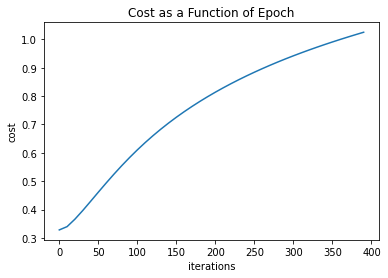

(0.8849833333333333, 1.0324280549194351)

In [7]:
model.fit(X_train, y_train, epoch = 400)  # train model

I have tried various learning rates and this one seems to give the best training accuracy. Oddly enough, the cost rises as a function of epoch even though the training accuracy increases. At first I though this was overfitting but the validation accuracy in the next section shows that is not the case. I find this very curious...

#Running Model on Unseen Test Set:

In [8]:
preds = model.predict(X_test, y_test)  # The model has never seen this test data

confusion_matrix(np.squeeze(y_test.T), preds, labels=[0,1,2,3,4,5,6,7,8,9], sample_weight=None, normalize=None)


Validation Acc: 0.8943


array([[ 943,    0,    3,    3,    0,    6,   19,    2,    4,    0],
       [   0, 1114,    3,    4,    0,    2,    4,    0,    8,    0],
       [  10,   14,  891,   24,   15,    1,   22,   17,   31,    7],
       [   5,    2,   23,  907,    1,   27,    3,   16,   12,   14],
       [   1,    6,    5,    0,  891,    1,   17,    1,    6,   54],
       [  15,    3,    8,   44,   20,  742,   17,   10,   20,   13],
       [  12,    3,   12,    1,   10,   17,  898,    2,    3,    0],
       [   2,   25,   26,    4,   12,    0,    1,  916,    3,   39],
       [  10,   12,   17,   49,   19,   43,   18,   14,  766,   26],
       [  10,    8,    5,   11,   49,   17,    3,   25,    6,  875]])

# Running Unlabeled Data Through the Model:

In [9]:
first10 = X_test[:, 0:10].reshape((784,10))  

# Running first10 test through without labels makes the model return predicitions and confidence
model.predict(first10)


Prediction Complete (prediction, confidence):


[(7, 1.0),
 (2, 0.93),
 (1, 0.99),
 (0, 1.0),
 (4, 0.94),
 (1, 0.99),
 (4, 0.92),
 (9, 0.92),
 (6, 0.57),
 (9, 0.8)]